<a href="https://colab.research.google.com/github/tapan8455/webdeveloping/blob/master/ML_Project_Skin_Cancer_Classification_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Download and Extract dataset

Dataset Source: https://challenge2018.isic-archive.com/task3/

In [ ]:
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_Input.zip
!unzip -q ISIC2018_Task3_Training_Input.zip
!rm ISIC2018_Task3_Training_Input.zip
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Training_GroundTruth.zip
!unzip -q ISIC2018_Task3_Training_GroundTruth.zip
!rm ISIC2018_Task3_Training_GroundTruth.zip
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_Input.zip
!unzip -q ISIC2018_Task3_Validation_Input.zip
!rm ISIC2018_Task3_Validation_Input.zip
!wget -q https://isic-challenge-data.s3.amazonaws.com/2018/ISIC2018_Task3_Validation_GroundTruth.zip
!unzip -q ISIC2018_Task3_Validation_GroundTruth.zip
!rm ISIC2018_Task3_Validation_GroundTruth.zip
!rm */*.txt

In [ ]:
from tensorflow import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
import keras.layers
import keras.models
import sklearn.model_selection
import sklearn.metrics
import sklearn
import pandas as pd
import numpy as np
import seaborn as sns
from keras import backend as K
import shutil
import matplotlib.pyplot as plt
import os
import cv2
%matplotlib inline

Reading Training and validation Data

In [ ]:
df_train = pd.read_csv("ISIC2018_Task3_Training_GroundTruth/ISIC2018_Task3_Training_GroundTruth.csv")
df_val = pd.read_csv("ISIC2018_Task3_Validation_GroundTruth/ISIC2018_Task3_Validation_GroundTruth.csv")

Create Directories to store Training and Validation images

In [ ]:
!mkdir Train Train/MEL Train/NV Train/BCC Train/AKIEC Train/BKL Train/DF Train/VASC
!mkdir Validation Validation/MEL Validation/NV Validation/BCC Validation/AKIEC Validation/BKL Validation/DF Validation/VASC

Sort Training and Validation images into directories earlier created based on class labels from the given .csv files

In [ ]:
for i in range(len(df_train)):
  if df_train["MEL"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/MEL")
  if df_train["NV"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/NV")
  if df_train["BCC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/BCC")
  if df_train["AKIEC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/AKIEC")
  if df_train["BKL"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/BKL")
  if df_train["DF"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/DF")
  if df_train["VASC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Training_Input/" + df_train["image"][i] + ".jpg", "/content/Train/VASC")

for i in range(len(df_val)):
  if df_val["MEL"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/MEL")
  if df_val["NV"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/NV")
  if df_val["BCC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/BCC")
  if df_val["AKIEC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/AKIEC")
  if df_val["BKL"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/BKL")
  if df_val["DF"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/DF")
  if df_val["VASC"][i] == 1: shutil.move("/content/ISIC2018_Task3_Validation_Input/" + df_val["image"][i] + ".jpg", "/content/Validation/VASC")


Display resized examples from each class

Class :  MEL


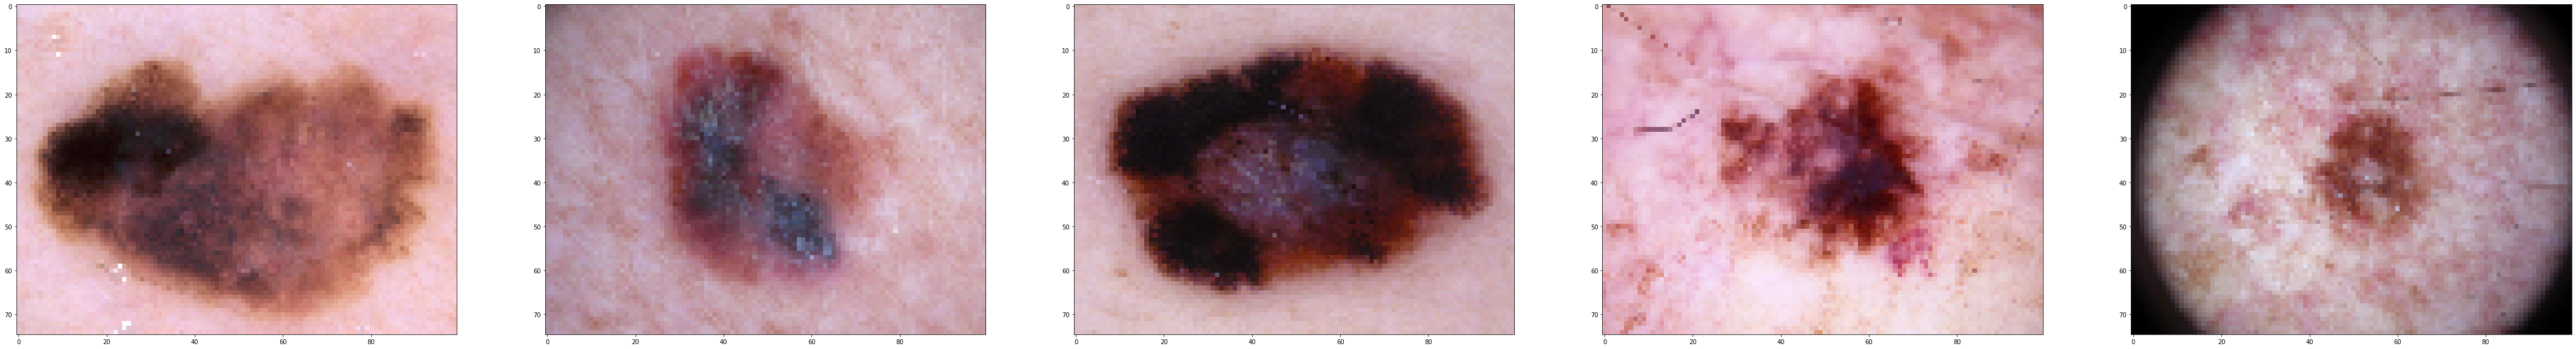

Class :  NV


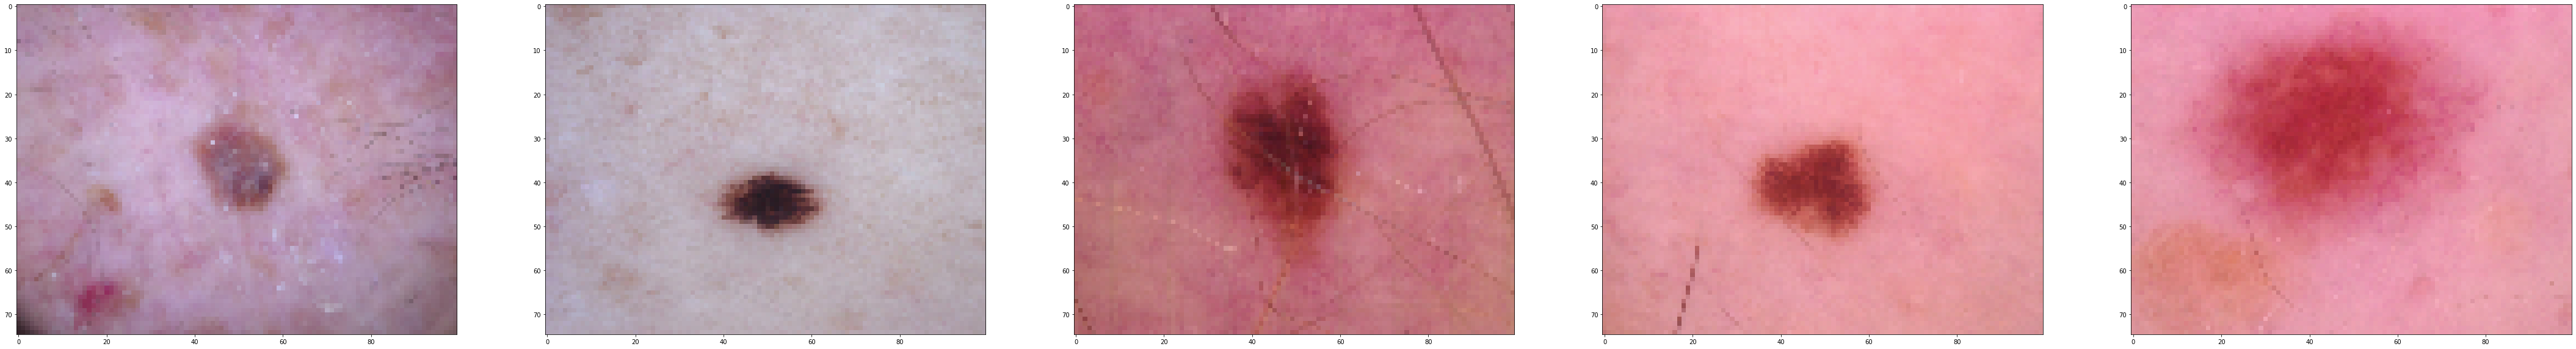

Class :  BCC


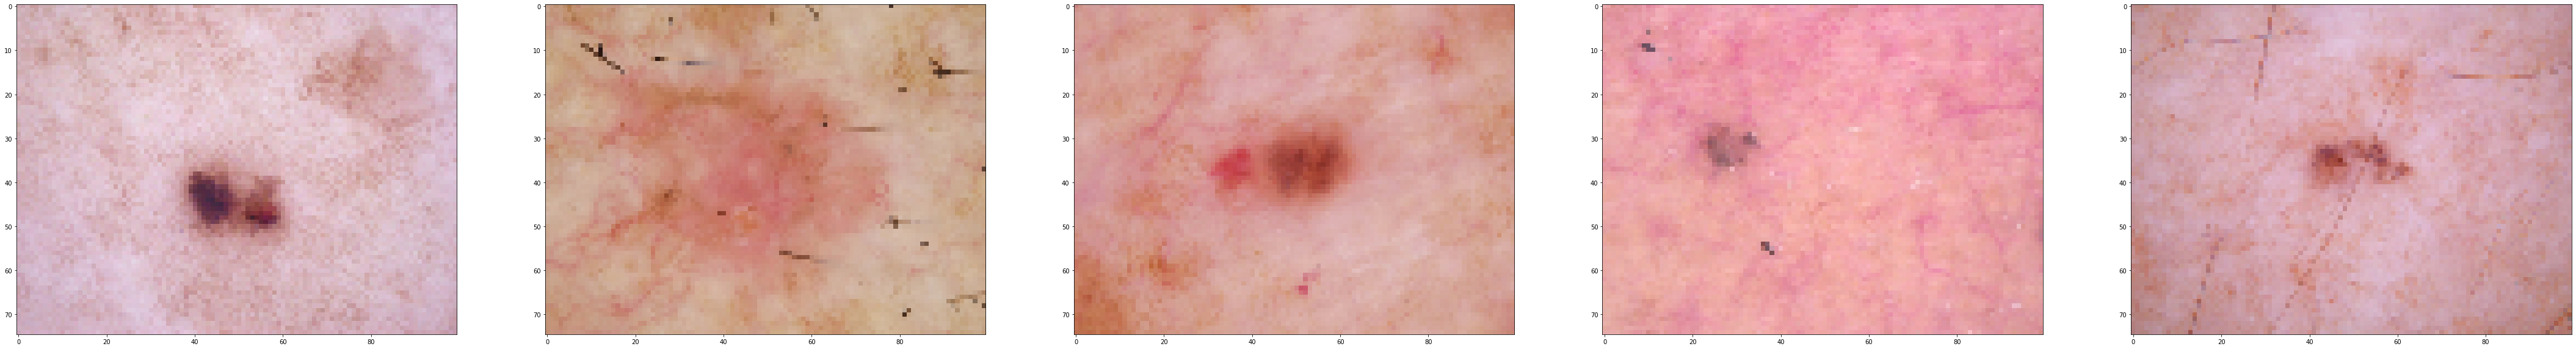

Class :  AKIEC


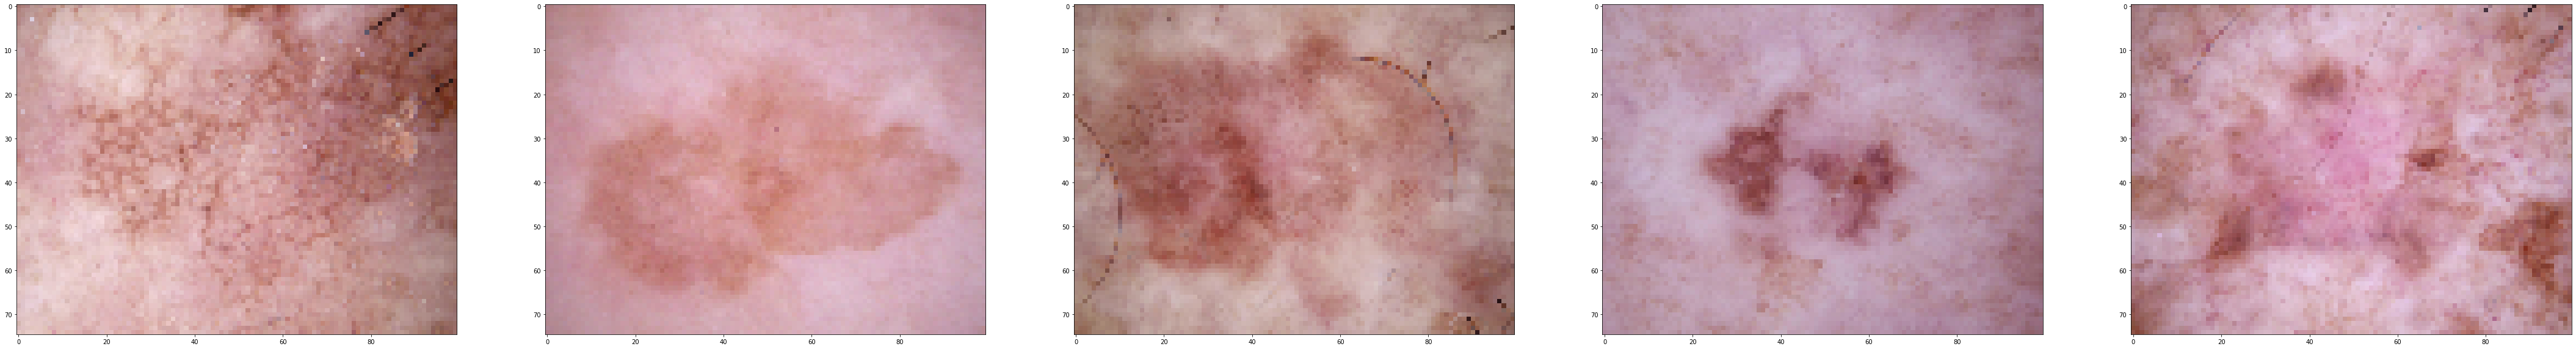

Class :  BKL


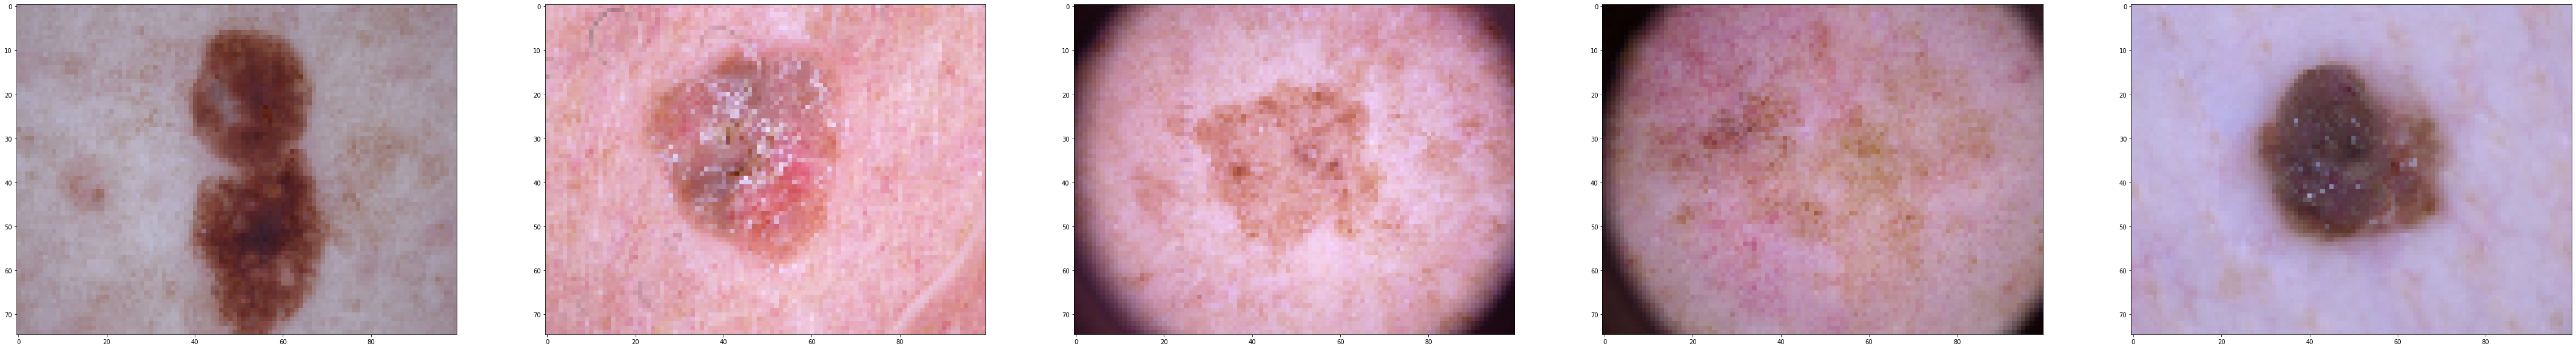

Class :  DF


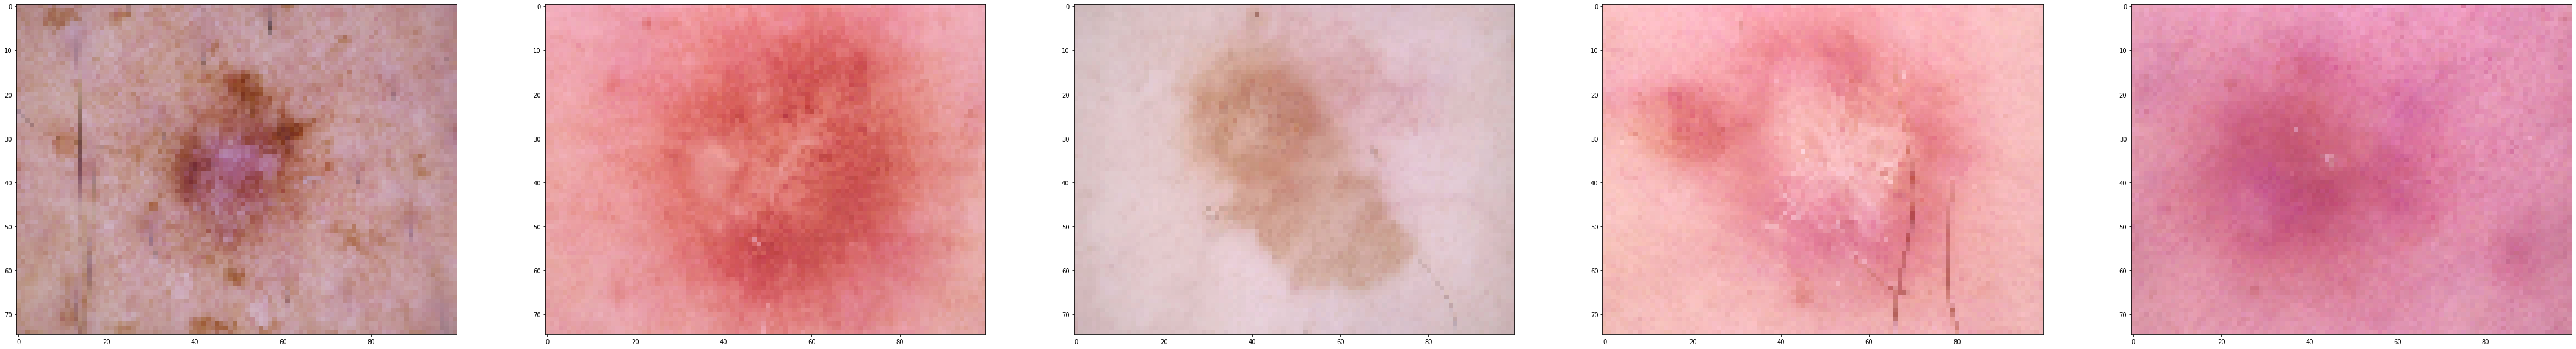

Class :  VASC


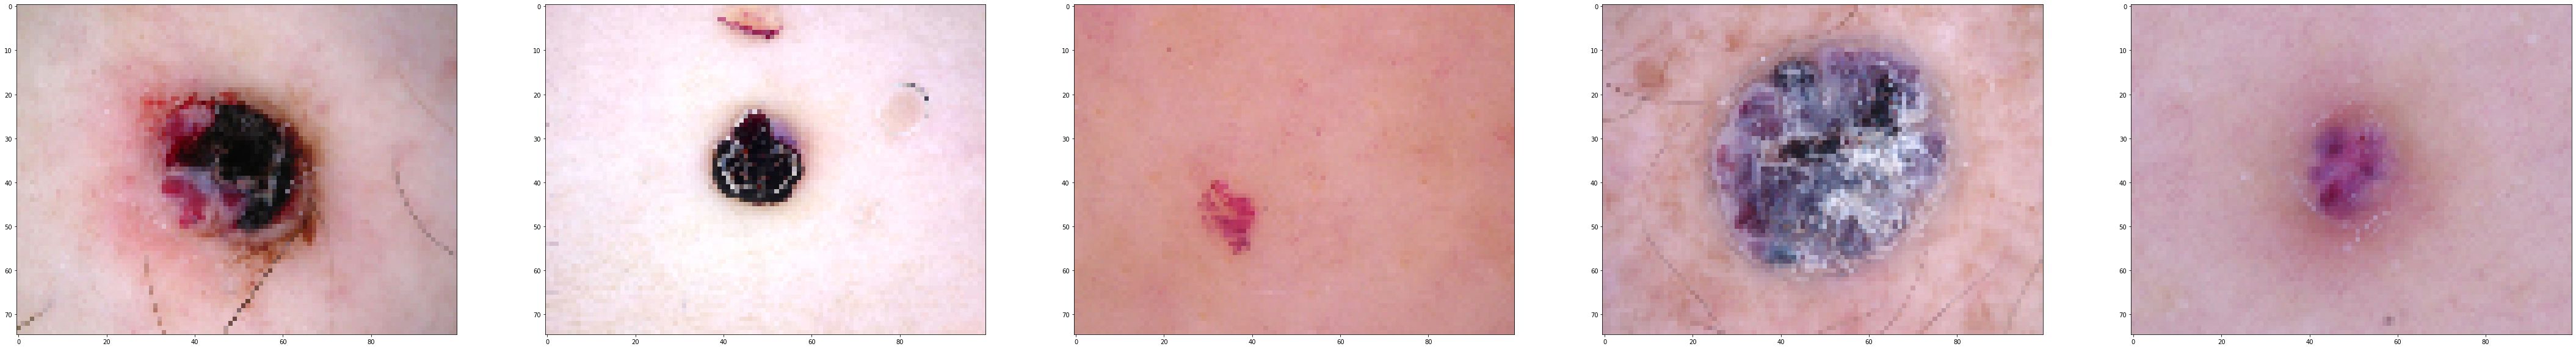

In [ ]:
class_types = ['MEL', 'NV', 'BCC', 'AKIEC', 'BKL', 'DF', 'VASC']
for class_type in class_types:
  path_of_class = '/content/Train/' + class_type + '/'
  file_list = os.listdir(path_of_class)
  img_list = []
  for i in range(5):
    image = cv2.imread(path_of_class + file_list[i], cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (100,75))
    img_list.append(image)
  f, axarr = plt.subplots(1,5, figsize=(75, 100))
  print("Class : ", class_type)
  for i in range(5):
    axarr[i].imshow(img_list[i])
  plt.show()

Read Dataset and augment images. We would use 20% of images from training set as test set

In [ ]:
datagen = ImageDataGenerator(rescale=1./255,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1,
        validation_split=0.2) 

datagen2 = ImageDataGenerator(rescale=1./255,
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1)

traingenerator = datagen.flow_from_directory(
        'Train',
        target_size=(75, 100),
        seed=0,
        batch_size=100,
        subset='training',
        class_mode='categorical')

testgenerator = datagen.flow_from_directory(
        'Train',
        target_size=(75, 100),
        seed=0,
        batch_size=100,
        subset='validation',
        class_mode='categorical')

valgenerator = datagen2.flow_from_directory(
        'Validation',
        target_size=(75, 100),
        seed=0,
        batch_size=100,
        class_mode='categorical')

Found 8015 images belonging to 7 classes.
Found 2000 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


Count datapoints (images) from each class

{'AKIEC': 0, 'BCC': 1, 'BKL': 2, 'DF': 3, 'MEL': 4, 'NV': 5, 'VASC': 6}


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


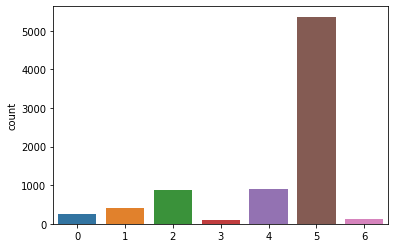

In [ ]:
class_freq = np.unique(traingenerator.classes, return_counts=True)
class_index = traingenerator.class_indices
COUNT_AKIEC, COUNT_BCC, COUNT_BKL, COUNT_DF, COUNT_MEL, COUNT_NV, COUNT_VASC = class_freq[1]
sns.countplot(traingenerator.classes)
print(class_index)

As we can see that our data is highly imbalanced, expecially when classes NV and DF are considered

In [ ]:
print("Class name   no. of samples")
for c_name, freq in zip(class_index.keys(), class_freq[1]):
  print("{: >8} {: >10}".format(c_name, freq))

Class name   no. of samples
   AKIEC        262
     BCC        412
     BKL        880
      DF         92
     MEL        891
      NV       5364
    VASC        114


Since our dataset is highly imbalanced, we will use "weighted" approach to training, where we would use inverse of ratios of total samples of a class to total number of samples in the dataset

In [ ]:
TRAIN_IMG_COUNT = len(traingenerator.classes)
weight_for_0 = (1 / COUNT_AKIEC)*(TRAIN_IMG_COUNT)/100
weight_for_1 = (1 / COUNT_BCC)*(TRAIN_IMG_COUNT)/100
weight_for_2 = (1 / COUNT_BKL)*(TRAIN_IMG_COUNT)/100
weight_for_3 = (1 / COUNT_DF)*(TRAIN_IMG_COUNT)/100
weight_for_4 = (1 / COUNT_MEL)*(TRAIN_IMG_COUNT)/100
weight_for_5 = (1 / COUNT_NV)*(TRAIN_IMG_COUNT)/100
weight_for_6 = (1 / COUNT_VASC)*(TRAIN_IMG_COUNT)/100
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3, 4: weight_for_4, 5: weight_for_5, 6: weight_for_6}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))
print('Weight for class 4: {:.2f}'.format(weight_for_4))
print('Weight for class 5: {:.2f}'.format(weight_for_5))
print('Weight for class 6: {:.2f}'.format(weight_for_6))

Weight for class 0: 0.31
Weight for class 1: 0.19
Weight for class 2: 0.09
Weight for class 3: 0.87
Weight for class 4: 0.09
Weight for class 5: 0.01
Weight for class 6: 0.70


In [ ]:
def create_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Conv2D(filters=16, kernel_size=(3, 3), activation='relu', input_shape=(75, 100, 3)))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
  model.add(tf.keras.layers.MaxPool2D(pool_size=(2, 2)))
  model.add(tf.keras.layers.BatchNormalization())

  model.add(tf.keras.layers.Flatten())
  model.add(tf.keras.layers.Dense(units=2048, activation='relu'))
  model.add(tf.keras.layers.Dropout(0.1))
  model.add(tf.keras.layers.Dense(units=256, activation='relu'))
  model.add(tf.keras.layers.Dense(units=7, activation='softmax'))

  model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy', 'Recall', 'Precision', 'TruePositives', 'TrueNegatives', 'FalsePositives', 'FalseNegatives'])

  return model

Minimize val_loss

In [ ]:
model_val_loss = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min',restore_best_weights=True, verbose=1)
history_val_loss = model_val_loss.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback])

Epoch 1/150
81/81 [==============================] - 160s 2s/step - loss: 0.8657 - accuracy: 0.6893 - recall: 0.5884 - precision: 0.8073 - true_positives: 4716.0000 - true_negatives: 46964.0000 - false_positives: 1126.0000 - false_negatives: 3299.0000 - val_loss: 1.6321 - val_accuracy: 0.1140 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 155s 2s/step - loss: 0.7421 - accuracy: 0.7273 - recall: 0.6362 - precision: 0.8255 - true_positives: 5099.0000 - true_negatives: 47012.0000 - false_positives: 1078.0000 - false_negatives: 2916.0000 - val_loss: 1.2523 - val_accuracy: 0.6632 - val_recall: 0.4663 - val_precision: 0.9091 - val_true_positives: 90.0000 - val_true_negatives: 1149.0000 - val_false_positives: 9.0000 - val_false_negatives: 103.0000
Epoch 3/150
81/81 [==============================] - 156s 2

In [ ]:
eval_val_loss = model_val_loss.evaluate(testgenerator) #early stopping - val_loss

20/20 [==============================] - 37s 2s/step - loss: 0.6947 - accuracy: 0.7525 - recall: 0.7040 - precision: 0.8027 - true_positives: 1408.0000 - true_negatives: 11654.0000 - false_positives: 346.0000 - false_negatives: 592.0000


Minimize val_loss - with class weights

In [ ]:
model_val_loss_weighted = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, mode='min',restore_best_weights=True, verbose=1)
history_val_loss_weighted = model_val_loss_weighted.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback], class_weight=class_weight)

Epoch 1/150
81/81 [==============================] - 157s 2s/step - loss: 0.1161 - accuracy: 0.4140 - recall: 0.2530 - precision: 0.6762 - true_positives: 2028.0000 - true_negatives: 47119.0000 - false_positives: 971.0000 - false_negatives: 5987.0000 - val_loss: 2.7178 - val_accuracy: 0.0777 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 152s 2s/step - loss: 0.0983 - accuracy: 0.4823 - recall: 0.3342 - precision: 0.7046 - true_positives: 2679.0000 - true_negatives: 46967.0000 - false_positives: 1123.0000 - false_negatives: 5336.0000 - val_loss: 3.2510 - val_accuracy: 0.0881 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 3/150
81/81 [==========================

In [ ]:
eval_val_loss_weighted = model_val_loss_weighted.evaluate(testgenerator) #early stopping - val_loss

20/20 [==============================] - 26s 1s/step - loss: 0.8061 - accuracy: 0.7045 - recall: 0.6175 - precision: 0.8072 - true_positives: 1235.0000 - true_negatives: 11705.0000 - false_positives: 295.0000 - false_negatives: 765.0000


Maximize val_accuracy

In [ ]:
model_val_accuracy = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, mode='max',restore_best_weights=True, verbose=1)
history_val_accuracy = model_val_accuracy.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback])

Epoch 1/150
81/81 [==============================] - 160s 2s/step - loss: 0.8567 - accuracy: 0.6908 - recall: 0.5899 - precision: 0.8131 - true_positives: 4728.0000 - true_negatives: 47003.0000 - false_positives: 1087.0000 - false_negatives: 3287.0000 - val_loss: 1.9580 - val_accuracy: 0.0829 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 155s 2s/step - loss: 0.7455 - accuracy: 0.7235 - recall: 0.6265 - precision: 0.8277 - true_positives: 5021.0000 - true_negatives: 47045.0000 - false_positives: 1045.0000 - false_negatives: 2994.0000 - val_loss: 1.6209 - val_accuracy: 0.6891 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 3/150
81/81 [=========================

In [ ]:
eval_val_accuracy = model_val_accuracy.evaluate(testgenerator) #early stopping - val_accuracy

20/20 [==============================] - 33s 2s/step - loss: 0.7834 - accuracy: 0.7475 - recall: 0.7145 - precision: 0.7961 - true_positives: 1429.0000 - true_negatives: 11634.0000 - false_positives: 366.0000 - false_negatives: 571.0000


Maximize val_accuracy - with class weights

In [ ]:
model_val_accuracy_weighted = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=8, mode='max',restore_best_weights=True, verbose=1)
history_val_accuracy_weighted = model_val_accuracy_weighted.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback])

Epoch 1/150
81/81 [==============================] - 160s 2s/step - loss: 0.8967 - accuracy: 0.6847 - recall: 0.5787 - precision: 0.8087 - true_positives: 4638.0000 - true_negatives: 46993.0000 - false_positives: 1097.0000 - false_negatives: 3377.0000 - val_loss: 1.5079 - val_accuracy: 0.6373 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 155s 2s/step - loss: 0.7835 - accuracy: 0.7134 - recall: 0.6148 - precision: 0.8256 - true_positives: 4928.0000 - true_negatives: 47049.0000 - false_positives: 1041.0000 - false_negatives: 3087.0000 - val_loss: 1.7068 - val_accuracy: 0.1244 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1157.0000 - val_false_positives: 1.0000 - val_false_negatives: 193.0000
Epoch 3/150
81/81 [=============================

In [ ]:
eval_val_accuracy_weighted = model_val_accuracy_weighted.evaluate(testgenerator) #early stopping - val_accuracy

20/20 [==============================] - 35s 2s/step - loss: 0.6374 - accuracy: 0.7620 - recall: 0.7200 - precision: 0.8229 - true_positives: 1440.0000 - true_negatives: 11690.0000 - false_positives: 310.0000 - false_negatives: 560.0000


Maximize val_recall

In [ ]:
model_val_recall = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=8, mode='max',restore_best_weights=True, verbose=1)
history_val_recall = model_val_recall.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback])

Epoch 1/150
81/81 [==============================] - 159s 2s/step - loss: 0.8776 - accuracy: 0.6789 - recall: 0.5799 - precision: 0.8071 - true_positives: 4648.0000 - true_negatives: 46979.0000 - false_positives: 1111.0000 - false_negatives: 3367.0000 - val_loss: 1.6107 - val_accuracy: 0.2798 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 157s 2s/step - loss: 0.7654 - accuracy: 0.7163 - recall: 0.6216 - precision: 0.8167 - true_positives: 4982.0000 - true_negatives: 46972.0000 - false_positives: 1118.0000 - false_negatives: 3033.0000 - val_loss: 1.7751 - val_accuracy: 0.1192 - val_recall: 0.0466 - val_precision: 0.1915 - val_true_positives: 9.0000 - val_true_negatives: 1120.0000 - val_false_positives: 38.0000 - val_false_negatives: 184.0000
Epoch 3/150
81/81 [==============================] - 155s 2

In [ ]:
eval__val_recall = model_val_recall.evaluate(testgenerator) #early stopping - val_recall

20/20 [==============================] - 33s 2s/step - loss: 0.6393 - accuracy: 0.7610 - recall: 0.7145 - precision: 0.8222 - true_positives: 1429.0000 - true_negatives: 11691.0000 - false_positives: 309.0000 - false_negatives: 571.0000


Maximize val_recall - with class weights

In [ ]:
model_val_recall_weighted = create_model()
callback = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=8, mode='max',restore_best_weights=True, verbose=1)
history_val_recall_weighted = model_val_recall_weighted.fit(traingenerator, validation_data=valgenerator, shuffle=False, epochs=150, callbacks=[callback])

Epoch 1/150
81/81 [==============================] - 160s 2s/step - loss: 0.9022 - accuracy: 0.6785 - recall: 0.5773 - precision: 0.7996 - true_positives: 4627.0000 - true_negatives: 46930.0000 - false_positives: 1160.0000 - false_negatives: 3388.0000 - val_loss: 1.7875 - val_accuracy: 0.1192 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 2/150
81/81 [==============================] - 153s 2s/step - loss: 0.7670 - accuracy: 0.7127 - recall: 0.6223 - precision: 0.8164 - true_positives: 4988.0000 - true_negatives: 46968.0000 - false_positives: 1122.0000 - false_negatives: 3027.0000 - val_loss: 1.5435 - val_accuracy: 0.5492 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00 - val_true_positives: 0.0000e+00 - val_true_negatives: 1158.0000 - val_false_positives: 0.0000e+00 - val_false_negatives: 193.0000
Epoch 3/150
81/81 [=========================

In [ ]:
eval__val_recall_weighted = model_val_recall_weighted.evaluate(testgenerator) #early stopping - val_recall

20/20 [==============================] - 29s 1s/step - loss: 0.6713 - accuracy: 0.7620 - recall: 0.7135 - precision: 0.8335 - true_positives: 1427.0000 - true_negatives: 11715.0000 - false_positives: 285.0000 - false_negatives: 573.0000


val_loss plots

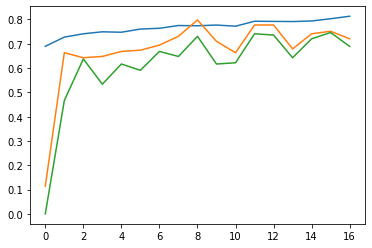

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_loss.history['accuracy'])
plt.plot(history_val_loss.history['val_accuracy'])
plt.plot(history_val_loss.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

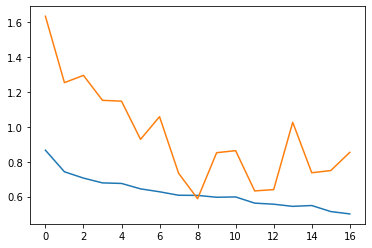

In [ ]:
plt.plot(history_val_loss.history['loss'])
plt.plot(history_val_loss.history['val_loss'])

val_loss - weighted

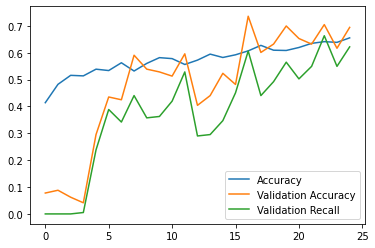

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_loss_weighted.history['accuracy'])
plt.plot(history_val_loss_weighted.history['val_accuracy'])
plt.plot(history_val_loss_weighted.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

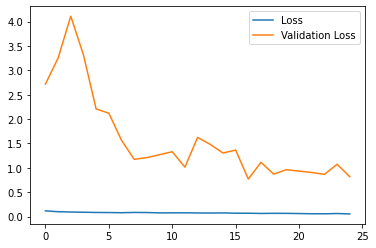

In [ ]:
plt.plot(history_val_loss_weighted.history['loss'])
plt.plot(history_val_loss_weighted.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

val_accuracy

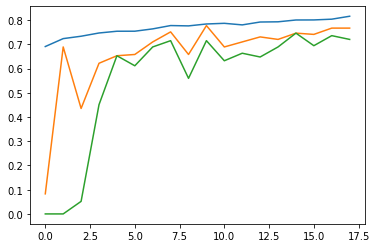

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_accuracy.history['accuracy'])
plt.plot(history_val_accuracy.history['val_accuracy'])
plt.plot(history_val_accuracy.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

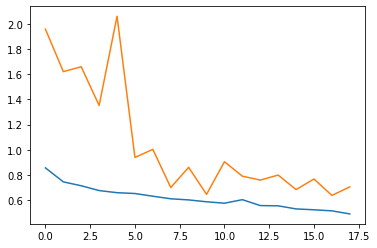

In [ ]:
plt.plot(history_val_accuracy.history['loss'])
plt.plot(history_val_accuracy.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

val_accuracy - weighted

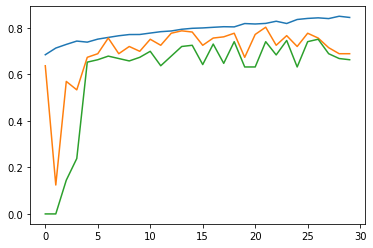

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_accuracy_weighted.history['accuracy'])
plt.plot(history_val_accuracy_weighted.history['val_accuracy'])
plt.plot(history_val_accuracy_weighted.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

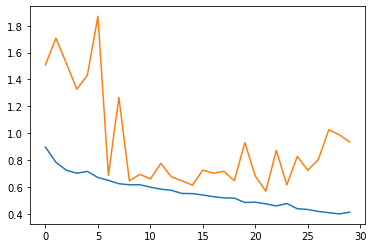

In [ ]:
plt.plot(history_val_accuracy_weighted.history['loss'])
plt.plot(history_val_accuracy_weighted.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

val_recall

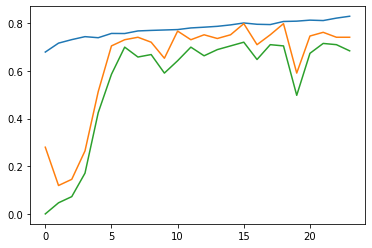

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_recall.history['accuracy'])
plt.plot(history_val_recall.history['val_accuracy'])
plt.plot(history_val_recall.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

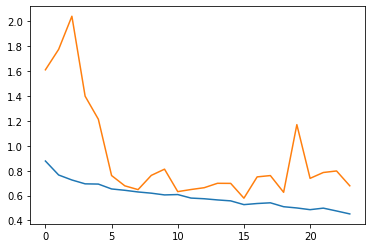

In [ ]:
plt.plot(history_val_recall.history['loss'])
plt.plot(history_val_recall.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

val_recall - weighted

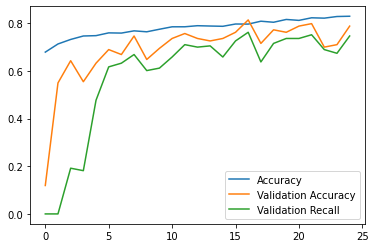

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history_val_recall_weighted.history['accuracy'])
plt.plot(history_val_recall_weighted.history['val_accuracy'])
plt.plot(history_val_recall_weighted.history['val_recall'])
plt.legend(['Accuracy', 'Validation Accuracy', 'Validation Recall'])

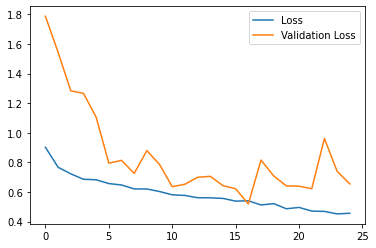

In [ ]:
plt.plot(history_val_recall_weighted.history['loss'])
plt.plot(history_val_recall_weighted.history['val_loss'])
plt.legend(['Loss', 'Validation Loss'])

In [ ]:
np.save('early_stopping__val_loss_custom_weights_history.npy',history.history)

In [ ]:
#history=np.load('50epoch-no_custom_weights_history.npy',allow_pickle='TRUE').item()

In [ ]:
model_val_loss.save("early_stopping__val_loss_custom_weights")

INFO:tensorflow:Assets written to: recall_early_stop-no_custom_weights/assets


In [ ]:
np.save('early_stopping__val_accuracy_custom_weights_history.npy',history.history)

In [ ]:
model_val_accuracy.save("early_stopping__val_accuracy_custom_weights")

In [ ]:
np.save('early_stopping__val_recall_custom_weights_history.npy',history.history)

In [ ]:
model_val_recall.save("early_stopping__val_recall_custom_weights")

In [ ]:
!zip -r recall_early_stop-no_custom_weights.zip recall_early_stop-no_custom_weights

  adding: recall_early_stop-no_custom_weights/ (stored 0%)
  adding: recall_early_stop-no_custom_weights/assets/ (stored 0%)
  adding: recall_early_stop-no_custom_weights/keras_metadata.pb (deflated 93%)
  adding: recall_early_stop-no_custom_weights/saved_model.pb (deflated 90%)
  adding: recall_early_stop-no_custom_weights/variables/ (stored 0%)
  adding: recall_early_stop-no_custom_weights/variables/variables.data-00000-of-00001 (deflated 12%)
  adding: recall_early_stop-no_custom_weights/variables/variables.index (deflated 73%)


In [ ]:
!unzip /content/early-stop-val_recall-custom_weights.zip

Archive:  /content/early-stop-val_recall-custom_weights.zip
   creating: early-stop-val_recall-custom_weights/assets/
  inflating: early-stop-val_recall-custom_weights/keras_metadata.pb  
  inflating: early-stop-val_recall-custom_weights/saved_model.pb  
   creating: early-stop-val_recall-custom_weights/variables/
  inflating: early-stop-val_recall-custom_weights/variables/variables.data-00000-of-00001  
  inflating: early-stop-val_recall-custom_weights/variables/variables.index  


In [ ]:
!mv /content/early-stop-val_recall-custom_weights/* /content

In [ ]:
model = tf.keras.models.load_model("early-stop-val_recall-custom_weights")

List of Convolutional Layers in the model

In [ ]:
for layer in model.layers:
  if 'conv' in layer.name:
    filters, biases = layer.get_weights()
    print(layer.name, filters.shape)

conv2d_24 (3, 3, 3, 16)
conv2d_25 (3, 3, 16, 32)
conv2d_26 (3, 3, 32, 64)
conv2d_27 (3, 3, 64, 64)
conv2d_28 (3, 3, 64, 128)
conv2d_29 (3, 3, 128, 128)


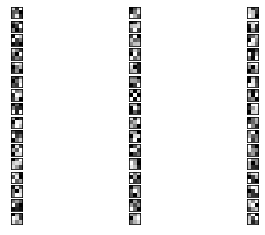

In [ ]:
filters, biases = model.layers[0].get_weights()
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)
n_filters, ix = filters.shape[-1], 1
for i in range(n_filters):
  # get the filter
  f = filters[:, :, :, i]
  # plot each channel separately
  for j in range(3):
    # specify subplot and turn of axis
    ax = plt.subplot(n_filters, 3, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    plt.imshow(f[:, :, j], cmap='gray')
    ix += 1
# show the figure
plt.show()

In [ ]:
test_file_names = testgenerator.filenames
sample_indexes = []
class_index_keys = list(class_index.keys())
for j in range(len(class_index_keys)):
  for i in range(len(test_file_names)):
    if test_file_names[i][test_file_names[i].find(class_index_keys[j]):len(class_index_keys[j])]: 
      sample_indexes.append(i)
      break

sample_AKIEC = "Train/" + test_file_names[sample_indexes[0]]
sample_BCC   = "Train/" + test_file_names[sample_indexes[1]]
sample_BKL   = "Train/" + test_file_names[sample_indexes[2]]
sample_DF    = "Train/" + test_file_names[sample_indexes[3]]
sample_MEL   = "Train/" + test_file_names[sample_indexes[4]]
sample_NV    = "Train/" + test_file_names[sample_indexes[5]]
sample_VASC  = "Train/" + test_file_names[sample_indexes[6]]

In [ ]:
pyplot.rcParams['figure.figsize'] = [30, 5]

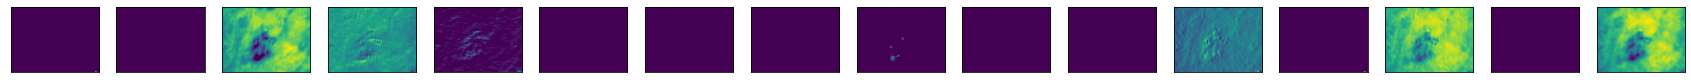

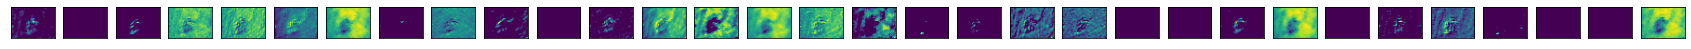

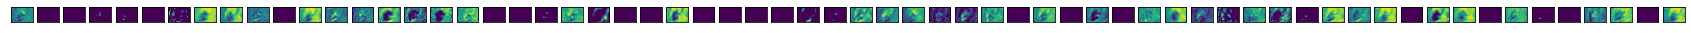

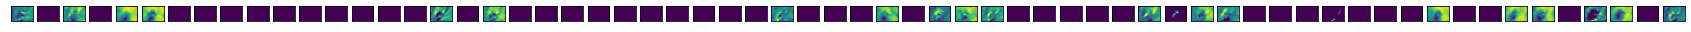

In [ ]:
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
from matplotlib import pyplot
from numpy import expand_dims
# load the model
ixs = [0, 3, 6, 7, 10, 11]
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
# load the image with the required shape
img = load_img(sample_AKIEC, target_size=(75, 100), color_mode='rgb')
# convert the image to an array
img = img_to_array(img)
# expand dimensions so that it represents a single 'sample'
img = expand_dims(img, axis=0)

# get feature map for first hidden layer
feature_maps = model.predict(img)
# plot the output from each block
for fmap in feature_maps:
  # plot all 64 maps in an 8x8 squares
  ix = 1
  dim = fmap.shape[-1]
  #	for _ in range(square):
  for _ in range(dim):
    # specify subplot and turn of axis
    ax = pyplot.subplot(1, dim, ix)
    ax.set_xticks([])
    ax.set_yticks([])
    # plot filter channel in grayscale
    pyplot.imshow(fmap[0, :, :, ix-1])
    ix += 1
	# show the figure
  #pyplot.gcf().set_size_inches(10,50)
  pyplot.show()

In [ ]:
traingenerator.next()

array([[0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0.],
 